# An Introduction to Ethical Supervised Learning

<hr/>

# Overview
In this tutorial, you will learn:
<ol>
<li> How to identify a discriminatory machine learning predictor</li>
<li> An introduction to fairness models in supervised learning</li>
<li> How to fix a basic discriminatory predictor with a fairness model through:
    <ul>
    <li> Understanding perfmorance metrics</li>
    <li> Minimizing loss</li>
    <li> Utilizing sensitivity / recall</li>
    </ul>
</li>
</ol>

<hr/>

# Part 1 : How to Identify a Discriminatory Predictor

## I. Introduction to TransRisk Scores

For this tutorial, we will be working with <b>TransRisk Scores</b> for four demographics. TransRisk scores aim to estimate how worthy a consumer is for credit. The scores range from 0 to 100, and are created using a variety of data points (such as history of paying back loans, how many credit card accounts you've had, employment rate, etc.) In theory, the closer a person's TransRisk score is to 100, the more likely they are to pay back a loan (similar to a FICO credit score). Banks and loan agencies typically use this kind of score combined with a <b>threshold value</b> to decide if someone should be granted a loan.<br/><br/>
For example, a bank that grants loans might set their threshold TransRisk score at 60. Then everyone with a TransRisk score of 60 or above recieves a loan, and everyone with a score below 60 automatically gets denied.<br/><br/>
The first data set you will work with shows the probability of an individual having a TransRisk score for different demographic groups. This can also be written as : 
<h3 align='center'> P(Score = x | race)</h3>

In [1]:
import pandas as pd
%matplotlib inline
import numpy as np

In [2]:
# ProbOfBeingScore = pd.read_csv("ProbOfBeingScore.csv").set_index("TransRisk Score")
ProbScoreEqualsXGivenRace = pd.read_csv("ProbScoreEqualsXGivenRace.csv").set_index("Score")
ProbScoreEqualsXGivenRace.head()

,White,Black,Hispanic,Asian
Score,,,,
0.0,0.0000,0.0000,0.0000,0.0000
0.5,0.0025,0.0112,0.0046,0.0013
1.0,0.0090,0.0414,0.0175,0.0075
1.5,0.0027,0.0114,0.0052,0.0019
2.0,0.0037,0.0142,0.0075,0.0025


## II. Using Visualizations as a Guide

*** For a threshold score x, someone is given a loan if they have a TransRisk score >= x. Using this data set, create and plot a dataframe that shows the probability of an individual receiving a loan: ***
<h3 align='center'> P(score >= x | race)</h3>

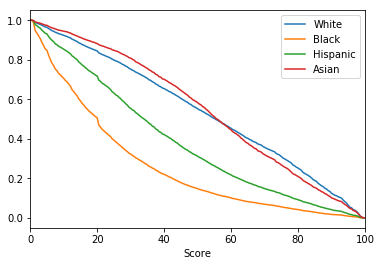

In [3]:
ProbOfGettingLoan = ProbScoreEqualsXGivenRace.iloc[::-1].cumsum()[::-1]
ProbOfGettingLoan.plot.line()

## III. Interpretation

Using our previous example of a threshold score x = 60, take a look at your visualization. With a score of 60, what is the probability for an individual of each race to receive a loan?

In [4]:
# Show Probabilities Here
ProbOfGettingLoan.loc[60]

White       0.4535
Black       0.1015
Hispanic    0.2176
Asian       0.4455
Name: 60.0, dtype: float64

Keep in mind this isn't an indication if discrimination is occurring or not. If a bank chooses a threshold score of 60, the white demographic would be more than 4x as likely to get a loan than the black demographic. This could happen for a variety of reasons, including (but not limited to):
- The data that was used to create a TransRisk score (such as amount of bank accounts opened) might unintentionally discriminate against certain demographic groups.
- Machine learning predictors are inherently less accurate for minority populations, since smaller population sizes lead to lower predictor performance.
- For a person have a score of 60 or above in the hispanic or black demographic, they likely will need to be in a much higher percentile of their overall population as compared to the white or asian demographic

** To determine if a predictor is discriminatory, it must fail the requirements provided by a fairness model. **

<hr/>

# Part 2 : Introduction to Fairness Models

## I. What is a fairness model?

Fairness models seek to fix predictors for discrimination. Specifically, they allow data scientists to algorithmically and statistically measure how <i>fair</i> a predictor is by providing requirements to ensure <i>fairness</i>. Using these requirements, we can also determine if a predictor is <i>unfair</i> (or discriminatory).

## II. Equal Opportunity Model

This model will work well for the TransRisk dataset, because it provides simple requirements for a binary predictor. This model takes into account three factors:
<ol>
<li>Groups that are defined by a protected attribute (this will be the four demographic groups in our example) | Denoted as 'A'</li>
<li>The advantaged outcome group (we will discuss this in Part 3) | Denoted as 'Y = 1'</li>
<li>The binary predictor (getting granted a loan) | Denoted as '$\hat Y$ = 1' for a loan approval and '$\hat Y$ = 0' for loan denial</li>
</ol>

A Predictor is said to satisfy fairness under Equal Opportunity iff the probability of getting a positive prediction is the same for all advantaged outcome members in a protected group. <br/><br/>
<div align='center'>
** P($\hat Y$ = 1 | A = a, Y = 1) is equal for ALL protected groups a. **</div>


<hr/>

# Part 3 : Fixing a Discriminatory Predictor Through the Equal Opportunity Model

## I. Understanding Performance Metrics

![Probabilities](ethicalmldiagram.png)

Here we will introduce two more data sets on these TransRisk scores. 
<ol>
<li><b>ProbNonDefaultGivenRace </b>: P(NonDefault | race)
    <ul>
    <li> Represents the probability that an individual of a race is non-defaulting</li>
    <li> <i>Note that the non-defaulters represent the advantaged outcome group defined in Part 2, for all non-defaulting individuals of a race,'Y = 1'</i></li>
    </ul>
</li><br/>
<li><b>ProbNonDefaultGivenScoreGreaterXAndRace </b> : P(NonDefault | score >= x, race)
    <ul>
    <li> Represents the probability that an individual who has been granted a loan is actually a non-defaulter</li>
    <li><i>Remember that with a threshold score x, everyone with a score >= x is granted a loan.</i></li>
    </ul>
</li>
</ol>

Read them in and make sure you understand what the data represents before moving onto the next section.

In [5]:
ProbNonDefaultGivenRace = pd.read_csv("ProbNonDefaultGivenRace.csv")
# need to use the old dataset until I figure out what the rounding error is coming from
# if I use the csv that is commented out, it yeilds a result that puts
# the asian threshold lower than the hispanic threshold.
ProbLoanReceiverIsNonDefault = (
    pd.read_csv("ProbLoanReceiverIsGood.csv")
    .set_index("TransRisk Score"))
# ProbLoanReceiverIsNonDefault = (
#     pd.read_csv("ProbNonDefaultGivenScoreGreaterXAndRace.csv")
#     .set_index('Score'))
# ProbLoanReceiverIsNonDefault.index.rename('TransRisk Score', inplace=True)

In [6]:
ProbLoanReceiverIsNonDefault.head()

,asian,black,hispanic,white
TransRisk Score,,,,
0.0,0.800660,0.315384,0.550650,0.759261
0.5,0.800660,0.315384,0.550650,0.759261
1.0,0.801702,0.318908,0.553099,0.761164
1.5,0.807309,0.331898,0.562799,0.767862
2.0,0.808860,0.335718,0.565808,0.769890


In [7]:
ProbOfGettingLoan.head()

,White,Black,Hispanic,Asian
Score,,,,
0.0,0.9999,0.9993,0.9999,1.0000
0.5,0.9999,0.9993,0.9999,1.0000
1.0,0.9974,0.9881,0.9953,0.9987
1.5,0.9884,0.9467,0.9778,0.9912
2.0,0.9857,0.9353,0.9726,0.9893


<hr/>

<div align='center'>

<h3> The General Multiplication Rule:</h3><br/>
<b>Definition : </b> For any two events, we can say that
<h4 > P(A and B) = P(A) * P(B | A)</h4><br/>
<i>"The probability that both A and B occur = the probability that A occurs multiplied by the probability that B occurs, given that A has occured."</i></div>

<hr/>

To work with the conditions introduced by the Equal Opporunity Model, we need to find<br/>
<div align='center'>P($\hat Y$ = 1 | A = a, Y = 1)</div><br/>
For our case study, this would be the Probability that someone has received a loan, given their race and the fact that they are non-defaulting. Also stated:<br/>
<div align='center'>P(score >= x | race, NonDefault)<br/><i>If you look at the visual table of probabilities above, this is shown with the <b>PURPLE</b> boxes</i></div><br/>
Using your knowledge of the multiplication rule with all three data sets you have been given on TransRisk scores, create a DataFrame that shows this probability for each TransRisk score and demographic, then plot it to see what this data looks like.

In [8]:
ProbOfGettingLoan.columns = ProbOfGettingLoan.columns.str.lower()
ProbLoanReceiverIsNonDefault.columns = ProbLoanReceiverIsNonDefault.columns.str.lower()

In [9]:
white_s = (ProbOfGettingLoan[["white"]] * ProbLoanReceiverIsNonDefault[["white"]]) / ProbNonDefaultGivenRace["white"][0]
black_s = (ProbOfGettingLoan[["black"]] * ProbLoanReceiverIsNonDefault[["black"]]) / ProbNonDefaultGivenRace["black"][0]
asian_s = (ProbOfGettingLoan[["asian"]] * ProbLoanReceiverIsNonDefault[["asian"]]) / ProbNonDefaultGivenRace["asian"][0]
hispanic_s = (ProbOfGettingLoan[["hispanic"]] * ProbLoanReceiverIsNonDefault[["hispanic"]]) / ProbNonDefaultGivenRace["hispanic"][0]

In [10]:
# sensitivites rounded to two decimal points so they can be more easily used as indices
s = [white_s, black_s, asian_s, hispanic_s]
sensitivities = pd.concat(s, axis= 1).round(2)
sensitivities.head()

,white,black,asian,hispanic
Score,,,,
0.0,1.0,1.0,1.0,1.0
0.5,1.0,1.0,1.0,1.0
1.0,1.0,1.0,1.0,1.0
1.5,1.0,1.0,1.0,1.0
2.0,1.0,1.0,1.0,1.0


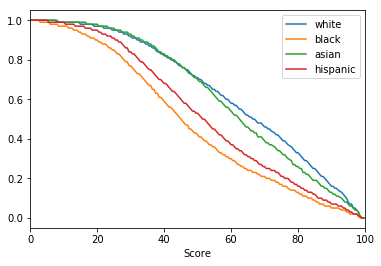

In [11]:
sensitivities.plot.line()

** Now, restructure this dataframe so the sensitivity values are the index, and each demographic has one TransRisk Score (threshold value) associated with each sensitivity **

In [12]:
# creating a dataframe with all possible rounded sensitivity values to be the index
totalDF = pd.DataFrame({
    'sensitivity': np.arange(0.0, 1.01, 0.01).tolist()
})

In [13]:
# function to format the threshold scores to match the sensitivity value at the index
def getScoreArray(race, data):
    scores = [None] * 101
    for index, row in data.iterrows():
        sens = data.loc[index][race]
        if(len(totalDF[totalDF['sensitivity'] == sens].index.values) >= 1):
            i = totalDF[totalDF['sensitivity'] == sens].index.values[0]
            scores[i] = index
    return scores

In [14]:
totalDF['t_white'] = getScoreArray('white', sensitivities[['white']])
totalDF['t_black'] = getScoreArray('black', sensitivities[['black']])
totalDF['t_asian'] = getScoreArray('asian', sensitivities[['asian']])
totalDF['t_hispanic'] = getScoreArray('hispanic', sensitivities[['hispanic']])

In [15]:
totalDF.set_index('sensitivity').head()

,t_white,t_black,t_asian,t_hispanic
sensitivity,,,,
0.00,100.0,99.5,100.0,99.5
0.01,98.5,98.0,98.5,98.5
0.02,NaN,97.5,NaN,97.5
0.03,98.0,95.0,98.0,96.0
0.04,97.5,94.0,97.5,95.0


## II. Minimizing Loss

For supervised learning predictors, one way to detect errors is to calculate the difference between the actual output and the predictor's output. The function used to compute the error of a predictor is called a <b>Loss Function</b>. For our dataset, we calculate loss in a similar manner to how banks giving loans would. Loss is calculated using False Positives (FP) and False Negatives (FN), which means every loss value can be associated with a precision value. Generally, banks strive for a maximum loss of 0.18, which correlates to a precision of 0.82. So, we want to make the <i><b>Precision = 0.82</b></i>.
<h3 align='center'> Precision = P(Y = 1 | $\hat Y$ = 1) == P(NonDefault | score >= x)</h3><br/>
Here we provide another dataset that shows the percentage of each demographic in the total sample size, or rather P(race). Using this information and the multiplication rule, find the precision for every demographic at every sensitivity value. So you should create four new columns in your sensitivity dataframe from before, one for each demographic precision.

In [16]:
# This represents P(race)
ProbOfBeingRace = pd.read_csv("ProbOfBeingRace.csv").set_index("Demographic")
ProbOfBeingRace

,P(race)
Demographic,
white,0.765109
black,0.104995
hispanic,0.084471
asian,0.045425


In [17]:
# function to order the precisions for each race in association with the demographic specific threshold value at
# each index. These are then summed for a total precision value to find the final sensitivity
def getPrecisionOrder(t_race, dataPrecision):
    prec = []
    for i in range(len(totalDF)):
        if(totalDF[t_race][i] != None):
            currPrec = dataPrecision[totalDF[t_race][i]]
            if(isinstance(currPrec, np.ndarray)):
                currPrec = 0
            prec.append(currPrec)
    return prec

In [18]:
# Calculate precision
asianPrecision = ProbLoanReceiverIsNonDefault["asian"] * ProbOfBeingRace.loc['asian']["P(race)"]
whitePrecision = ProbLoanReceiverIsNonDefault["white"] * ProbOfBeingRace.loc['white']["P(race)"]
blackPrecision = ProbLoanReceiverIsNonDefault["black"] * ProbOfBeingRace.loc['black']["P(race)"]
hispanicPrecision = ProbLoanReceiverIsNonDefault["hispanic"] * ProbOfBeingRace.loc['hispanic']["P(race)"]
totalDF['w_prec'] = getPrecisionOrder('t_white', whitePrecision)
totalDF['b_prec'] = getPrecisionOrder('t_black', blackPrecision)
totalDF['a_prec'] = getPrecisionOrder('t_asian', asianPrecision)
totalDF['h_prec'] = getPrecisionOrder('t_hispanic', hispanicPrecision)
totalDF.set_index('sensitivity', inplace=True)
totalDF.head()

,t_white,t_black,t_asian,t_hispanic,w_prec,b_prec,a_prec,h_prec
sensitivity,,,,,,,,
0.00,100.0,99.5,100.0,99.5,0.765109,0.104995,0.045425,0.084471
0.01,98.5,98.0,98.5,98.5,0.757606,0.100474,0.045347,0.084471
0.02,NaN,97.5,NaN,97.5,0.000000,0.101766,0.000000,0.083801
0.03,98.0,95.0,98.0,96.0,0.759574,0.102358,0.045385,0.083597
0.04,97.5,94.0,97.5,95.0,0.757619,0.101009,0.045334,0.083409


## III. Utilizing Sensitivity

We finally have all of the peices to fix the discriminatory predictor using the Equal Opportunity Model. As you just learned in Section II, our desired loss directly leads to a precision of 0.82. Looking back at the requirements for Equal Opportunity, we can see it requires that P($\hat Y$ = 1 | A = a, Y = 1) is equal for ALL protected groups a. This can also be stated that the <b>true positive rate</b> is equal for ALL protected groups a. Or even further, that the <b><i>Sensitivity</i></b> is equal for ALL protected groups a.<br/><br/>
If you look back at your plot of sensitivity values, you can see that choosing one sensitivity value (drawing a horizontal line on your plot) would yeild four threshold values. But where do we draw this line? Which singular sensitivity value do we want?<br/><br/>
As we saw in the last section, we choose the sensitivity value that gives us a total precision of 0.82. Now you simply need to find the threshold scores associated with that sensitivity value for each demographic. These scores represent the threshold that needs to be set for that particular demographic in order to satisfy 'fairness'. Finish by recording the final four threshold values needed to satisfy the Equal Opportunity Model.

** First: Aggregate the four precisions at each sensitivity value for a TOTAL PRECISION column in your dataframe. **

In [19]:
totalPrecision = (asianPrecision + whitePrecision + blackPrecision + hispanicPrecision).fillna(value=1)

In [20]:
totalDF['total_prec'] = totalDF[['w_prec', 'b_prec', 'a_prec', 'h_prec']].sum(axis=1)
totalDF.head()

,t_white,t_black,t_asian,t_hispanic,w_prec,b_prec,a_prec,h_prec,total_prec
sensitivity,,,,,,,,,
0.00,100.0,99.5,100.0,99.5,0.765109,0.104995,0.045425,0.084471,1.000000
0.01,98.5,98.0,98.5,98.5,0.757606,0.100474,0.045347,0.084471,0.987899
0.02,NaN,97.5,NaN,97.5,0.000000,0.101766,0.000000,0.083801,0.185567
0.03,98.0,95.0,98.0,96.0,0.759574,0.102358,0.045385,0.083597,0.990914
0.04,97.5,94.0,97.5,95.0,0.757619,0.101009,0.045334,0.083409,0.987371


*** What four sensitivity values are associated with a precision of 0.82? *** (put answer below)

In [21]:
closestPrecision = min(totalDF["total_prec"], key=lambda x:abs(x-0.82))
totalDF[totalDF['total_prec'] == closestPrecision]

,t_white,t_black,t_asian,t_hispanic,w_prec,b_prec,a_prec,h_prec,total_prec
sensitivity,,,,,,,,,
0.97,21.5,11.0,23.0,16.0,0.678919,0.046479,0.040767,0.05854,0.824704


<hr/>

# Results & Conclusions

<i><h4>Congratulations!</h4></i><br/> You have successfully taken a discriminatory predictor and utilized a machine learning fairness model to make it into a 'fair' predictor. 
<ul>
<li> Through visualizing the probability of a beneficial outcome, you could see that the probabilities for different demographics to receive loans weren't statistically close. This wasn't necessarily a measure of discrimination.</li>
<li> The Equal Opportunity Model provided a clear requirement to ensure fairness. As you learned later, this meant that the sensitivity (the true positive rate) of the predictor had to be the same for all races. Since one threshold value resulted in four different sensitivities, you were able to determine that discrimination will occur unless you choose one threshold per demographic.</li>
<li> Using loss minimization, you were able to use precision to find the single sensitivity that provided the least amount of loss.</li>
<li> Finally, you discovered four new threshold values to be used; one for each demographic. Ensuring fairness and fixing a discriminatory predictor.</li>
</ul>
<br/><br/>

<div align='center'><i>What other commonly found predictors do you think might be inherently discriminatory?</i></div>
<br/><br/>

TransRisk data and non-discriminatory analysis courtesy of https://arxiv.org/pdf/1610.02413.pdf